<a href="https://colab.research.google.com/github/andrealamanna/cnn_prediction_abnormalities_mammography/blob/main/Pretrained_CNN_BenMal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2**
## CNN Pretrained ben/mal classifications

#Perliminar phases

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns # Grouped bar plot
import itertools
import numpy as np
import pandas as pd 
import os 
import gc # Garbage Collector
from skimage import data, img_as_float
from skimage import exposure

from tensorflow import keras
from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from keras import layers, models, regularizers, metrics
from keras.models import load_model
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.utils import class_weight

from keras.applications.inception_v3 import InceptionV3

print("Done")

Done


In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      metrics.Precision(name='prec'),
      metrics.Recall(name='rec'),
      metrics.AUC(name='auc')
]

base_path = "/content/gdrive/My Drive/Colab Notebooks/DLProject/Lamanna/"

MODEL_PATH = os.path.join(base_path, "models/Pretrained")
PLOTS_PATH = os.path.join(base_path, "plots/Pretrained")
RESULT_PATH = os.path.join(base_path, "results/Ben_Mal/Scratch7BenMal")

train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

#file_path_out = os.path.join(RESULT_PATH, "top3_results.csv")
#file_path = os.path.join(RESULT_PATH, "results-CM.csv")
#model_path = os.path.join(MODEL_PATH, "best_model.h5")

print("Done")

Done


# Utility Functions

In [ ]:
# Remove baseline samples
def remove_baseline(samples): 
  max_index = int(len(samples)/2)
  indexes = [2*i + 1 for i in range(0, max_index)]

  return samples[indexes]

# Interchange the dataset index
def shuffle_dataset(i, j):
  indexes = tf.range(start=0, limit=tf.shape(i)[0], dtype=tf.int32)
  shuffled_indexes = tf.random.shuffle(indexes)

  i = tf.gather(i, shuffled_indexes)
  j = tf.gather(j, shuffled_indexes)

  i = i.numpy()
  j = j.numpy()

  return i, j

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
    # Malignant
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

#removing benign calcification for balancing
def remove_ben(samples, labels):
  unique, counts = np.unique(labels, return_counts=True)
  min_elems = np.min(counts)
  local_samples=np.zeros((min_elems*2,) + samples[0].shape)
  local_labels=np.zeros((min_elems*2,))
  
  count_ben = 0
  i = 0
  #for i in range(len(samples)):
  for sample, label in list(zip(samples,labels)):
    if (label == 0 and count_ben < min_elems):
      local_labels[i] = label
      local_samples[i] = sample
      count_ben += 1
      i += 1
    elif label == 1:
      local_labels[i] = label
      local_samples[i] = sample
      i += 1

  return local_samples, local_labels

Done


In [ ]:
#test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
def test_model(model):
  test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE)#,
                                      #callbacks=[GarbageCollectorCallback()])
  print("\n---------------------------------")
  print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
  print("Loss:", "%0.2f" % (test_loss), "%")
  print("Precision:", "%0.2f" % (test_precision*100), "%")
  print("Recall:", "%0.2f" % (test_recall*100), "%")
  print("AUC:", "%0.2f" % test_auc)
  print("---------------------------------\n")
  
print("Done")

Done


In [ ]:
def print_opt_results(history_0):
  # History of accuracy and loss
  tr_loss_0 = history_0.history['loss']
  tr_acc_0 = history_0.history['acc']
  tr_prec_0 = history_0.history['prec']
  tr_rec_0 = history_0.history['rec']
  val_loss_0 = history_0.history['val_loss']
  val_acc_0 = history_0.history['val_acc']
  val_prec_0 = history_0.history['val_prec']
  val_rec_0 = history_0.history['val_rec']

  # Total number of epochs training
  epochs_0 = range(1, len(tr_acc_0)+1)
  end_epoch_0 = len(tr_acc_0)

  # Epoch when reached the val acc max
  opt_epoch_0 = val_acc_0.index(max(val_acc_0)) + 1

  # Loss and accuracy on the validation set
  end_val_loss_0 = val_loss_0[len(val_loss_0)-1]
  end_val_acc_0 = val_acc_0[len(val_acc_0)-1]
  end_val_prec_0 = val_loss_0[len(val_prec_0)-1]
  end_val_rec_0 = val_acc_0[len(val_rec_0)-1]
  opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
  opt_val_acc_0 = val_acc_0[opt_epoch_0-1]
  opt_val_prec_0 = val_prec_0[opt_epoch_0-1]
  opt_val_rec_0 = val_rec_0[opt_epoch_0-1]

  print("Epoch [end]: %d" % end_epoch_0)
  print("Epoch [opt]: %d" % opt_epoch_0)
  print("Valid accuracy [end]: %.4f" % end_val_acc_0)
  print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
  print("Valid loss [end]: %.4f" % end_val_loss_0)
  print("Valid loss [opt]: %.4f" % opt_val_loss_0)
  print("Valid precision [end]: %.4f" % end_val_prec_0)
  print("Valid precision [opt]: %.4f" % opt_val_prec_0)
  print("Valid recall [end]: %.4f" % end_val_rec_0)
  print("Valid recall [opt]: %.4f" % opt_val_rec_0)

print("Done")

Done


In [ ]:
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  epochs = range(len(acc))
  plt.figure()
  plt.plot(epochs, acc, 'b', linestyle='dashed', label='Training accuracy',color='Green')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='Blue')
  plt.title('Training and validation accuracy')
  plt.legend()
  return plt

def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', linestyle='dashed', label='Training loss',color='cyan')
  plt.plot(epochs, val_loss, 'b', label='Validation loss',color='orange')
  plt.title('Training and validation loss')
  plt.legend()
  return plt

def plot_prec(history):
  prec = history.history['prec']
  val_prec = history.history['val_prec']
  epochs = range(len(prec))
  plt.figure()
  plt.plot(epochs, prec, 'b', linestyle='dashed', label='Training prec',color='red')
  plt.plot(epochs, val_prec, 'b', label='Validation prec',color='royalblue')
  plt.title('Training and validation prec')
  plt.legend()
  return plt

def plot_rec(history):
  rec = history.history['rec']
  val_rec = history.history['val_rec']
  epochs = range(len(rec))
  plt.figure()
  plt.plot(epochs, rec, 'b', linestyle='dashed', label='Training rec',color='chocolate')
  plt.plot(epochs, val_rec, 'b', label='Validation rec',color='navy')
  plt.title('Training and validation rec')
  plt.legend()
  return plt

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    precision = TP / (TP + FP)

    tpr = TP / (TP + FN)
    specificity = TN / (TN + FP)
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity
    # Visualization Data Histogram

def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=BATCH_SIZE+2,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt

print("Done")

Done


# Data operations

In [ ]:
train_images = np.load(train_img_path)
train_labels = np.load(train_label_path)
test_images = np.load(test_img_path)
test_labels = np.load(test_label_path)

#count quantity masses and calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)
print("Train dataset")
print("---------------------------------")
print("Masses: \t\t", counts[1]+counts[2])
print("Calcification: \t\t", counts[3]+counts[4])
print("---------------------------------")
print("Benign: \t\t", counts[1]+counts[3])
print("Malign: \t\t", counts[2]+counts[4])
print("---------------------------------")
print("Benign Masses: \t\t", counts[1])
print("Malign Masses: \t\t", counts[2])
print("Benign Calcification: \t", counts[3])
print("Malign Calcification: \t", counts[4])
print("---------------------------------")
print("Baseline: \t\t", counts[0])
print("---------------------------------")
print("Total: \t\t\t", counts[0]+counts[1]+counts[2]+counts[3]+counts[4])

#count quantity masses and calcifications
uniqueT, countsT = np.unique(test_labels, return_counts=True)
#print(unique, countsT)
print("\n")
print("Test dataset")
print("---------------------------------")
print("Masses: \t\t", countsT[1]+countsT[2])
print("Calcification: \t\t", countsT[3]+countsT[4])
print("---------------------------------")
print("Benign: \t\t", countsT[1]+countsT[3])
print("Malign: \t\t", countsT[2]+countsT[4])
print("---------------------------------")
print("Benign Masses: \t\t", countsT[1])
print("Malign Masses: \t\t", countsT[2])
print("Benign Calcification: \t", countsT[3])
print("Malign Calcification: \t", countsT[4])
print("---------------------------------")
print("Baseline: \t\t", countsT[0])
print("---------------------------------")
print("Total: \t\t\t", countsT[0]+countsT[1]+countsT[2]+countsT[3]+countsT[4])

Train dataset
---------------------------------
Masses: 		 1218
Calcification: 		 1458
---------------------------------
Benign: 		 1568
Malign: 		 1108
---------------------------------
Benign Masses: 		 620
Malign Masses: 		 598
Benign Calcification: 	 948
Malign Calcification: 	 510
---------------------------------
Baseline: 		 2676
---------------------------------
Total: 			 5352


Test dataset
---------------------------------
Masses: 		 179
Calcification: 		 157
---------------------------------
Benign: 		 219
Malign: 		 117
---------------------------------
Benign Masses: 		 113
Malign Masses: 		 66
Benign Calcification: 	 106
Malign Calcification: 	 51
---------------------------------
Baseline: 		 336
---------------------------------
Total: 			 672


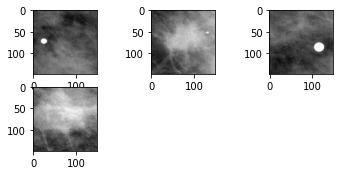

In [ ]:
images = range(0,4)
for i in images:
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
    
#Show the plot
plt.show()

In [ ]:
# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Mapping labels with standard index
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

# Suffle index (Previous dataset is ordered by index)
train_images, train_labels = shuffle_dataset(train_images, train_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


Ben samples:  1568
Mal samples:  1108


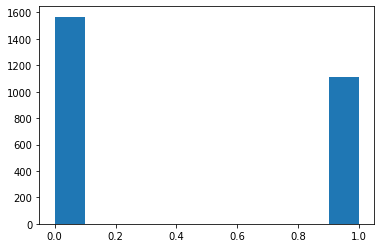

In [ ]:
#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Ben samples: ", counts[0])
print("Mal samples: ", counts[1])
plt.hist(train_labels)
plt.show()

In [ ]:
#trainref_images=train_images
#trainref_labels=train_labels
trainref_images, trainref_labels = remove_ben(train_images,train_labels)
print(len(trainref_images))
print(len(trainref_labels)) 

2216
2216


Ben samples:  1108
Mal samples:  1108


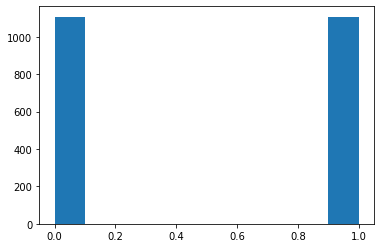

In [ ]:
#check if training dataset is balanced  
unique, counts = np.unique(trainref_labels, return_counts=True)
print("Ben samples: ", counts[0])
print("Mal samples: ", counts[1])
plt.hist(trainref_labels)
plt.show()

In [ ]:
# Prepare the data with the expected format
train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))
trainref_images = trainref_images.reshape(trainref_images.shape + (1,))

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)
print("Train refactor shape: ", trainref_images.shape)

Train shape:  (2676, 150, 150, 1)
Test shape:  (336, 150, 150, 1)
Train refactor shape:  (2216, 150, 150, 1)


In [ ]:
#Splitting training-validation with 80-20 %
split_index = int(0.8*len(train_images))
train_dataset_split = train_images[:split_index]
valid_dataset_split = train_images[split_index:]
train_labels_split = train_labels[:split_index]
valid_labels_split = train_labels[split_index:]

splitref_index = int(0.8*len(trainref_images))
trainref_dataset_split = trainref_images[:splitref_index]
validref_dataset_split = trainref_images[splitref_index:]
trainref_labels_split = trainref_labels[:splitref_index]
validref_labels_split = trainref_labels[splitref_index:]

print(train_dataset_split.shape)
print(valid_dataset_split.shape)
print(trainref_dataset_split.shape)
print(validref_dataset_split.shape)

(2140, 150, 150, 1)
(536, 150, 150, 1)
(1772, 150, 150, 1)
(444, 150, 150, 1)


In [ ]:
# All images will be rescaled by 1./65535 (max value range)
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
trainref_datagen = ImageDataGenerator(rescale=1./65535)
validref_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535)

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

# **CNN Definition**

##Inception V3

In [ ]:
train_dataset_split = np.repeat(train_dataset_split, 3, axis = 3)
valid_dataset_split = np.repeat(valid_dataset_split, 3, axis = 3)
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_dataset_split.shape)
print(test_images.shape)


(2140, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                      

In [ ]:
#from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
#valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
#test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [ ]:
# Train data augmentation. Deep Convolutional Neural Networks for breast cancer screening. Hiba Chougrada, Hamid Zouaki, Omar Alheyane b
train_datagen = ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    zoom_range=0.5, #0.5 - 1.5
    horizontal_flip=True,
    fill_mode='nearest'
   )

###Model 1

In [ ]:
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               4718848   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26,521,889
Trainable params: 4,719,105
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model1.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
history1 = model1.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 23s 346ms/step - loss: 0.6211 - acc: 0.6513 - prec: 0.5599 - rec: 0.7029 - auc: 0.7165 - val_loss: 0.5916 - val_acc: 0.6816 - val_prec: 0.6214 - val_rec: 0.6802 - val_auc: 0.7596
Epoch 2/100
66/66 [==============================] - 20s 298ms/step - loss: 0.6222 - acc: 0.6551 - prec: 0.5684 - rec: 0.6586 - auc: 0.7135 - val_loss: 0.5917 - val_acc: 0.6543 - val_prec: 0.5710 - val_rec: 0.8153 - val_auc: 0.7669
Epoch 3/100
66/66 [==============================] - 13s 192ms/step - loss: 0.6334 - acc: 0.6366 - prec: 0.5455 - rec: 0.6682 - auc: 0.7073 - val_loss: 0.5914 - val_acc: 0.6641 - val_prec: 0.5796 - val_rec: 0.8198 - val_auc: 0.7697
Epoch 4/100
66/66 [==============================] - 12s 182ms/step - loss: 0.6067 - acc: 0.6613 - prec: 0.5678 - rec: 0.7066 - auc: 0.7377 - val_loss: 0.5982 - val_acc: 0.6816 - val_prec: 0.6453 - val_rec: 0.5901 - val_auc: 0.7489
Epoch 5/100
66/66 [==============================] - 12s 177ms/step - lo

In [ ]:
model1.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model1.h5'))

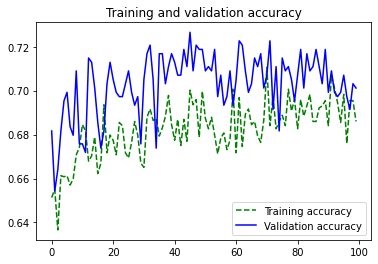

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history1)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model1_acc.png'))

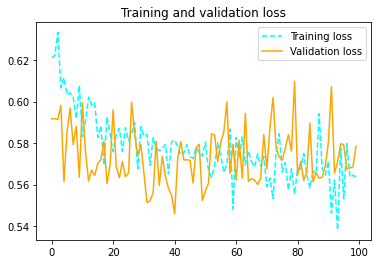

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history1)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model1_loss.png'))

In [ ]:
print_opt_results(history1)

Epoch [end]: 100
Epoch [opt]: 46
Valid accuracy [end]: 0.7012
Valid accuracy [opt]: 0.7266
Valid loss [end]: 0.5784
Valid loss [opt]: 0.5716
Valid precision [end]: 0.5784
Valid precision [opt]: 0.6783
Valid recall [end]: 0.7012
Valid recall [opt]: 0.7027


In [ ]:
test_model(model1)

10/10 [==============================] - 1s 51ms/step - loss: 0.6132 - acc: 0.6219 - prec: 0.4702 - rec: 0.7117 - auc: 0.7406

---------------------------------
Accuracy: 62.19 %
Loss: 0.61 %
Precision: 47.02 %
Recall: 71.17 %
AUC: 0.74
---------------------------------



###Model 2
Less node in dense layer and dropout 0.2

In [ ]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2359424   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24,162,337
Trainable params: 2,359,553
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model2.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
history2 = model2.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 18s 204ms/step - loss: 0.9495 - acc: 0.5951 - prec: 0.5012 - rec: 0.6207 - auc: 0.6368 - val_loss: 0.6112 - val_acc: 0.6602 - val_prec: 0.7162 - val_rec: 0.2573 - val_auc: 0.7038
Epoch 2/100
66/66 [==============================] - 12s 178ms/step - loss: 0.6475 - acc: 0.6314 - prec: 0.5488 - rec: 0.6689 - auc: 0.6971 - val_loss: 0.6025 - val_acc: 0.6484 - val_prec: 0.5586 - val_rec: 0.6019 - val_auc: 0.7205
Epoch 3/100
66/66 [==============================] - 12s 178ms/step - loss: 0.6439 - acc: 0.6494 - prec: 0.5681 - rec: 0.6682 - auc: 0.7165 - val_loss: 0.5979 - val_acc: 0.6797 - val_prec: 0.6105 - val_rec: 0.5631 - val_auc: 0.7353
Epoch 4/100
66/66 [==============================] - 12s 179ms/step - loss: 0.6152 - acc: 0.6490 - prec: 0.5679 - rec: 0.6697 - auc: 0.7222 - val_loss: 0.6229 - val_acc: 0.6328 - val_prec: 0.5298 - val_rec: 0.7767 - val_auc: 0.7297
Epoch 5/100
66/66 [==============================] - 12s 181ms/step - lo

In [ ]:
model2.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model2.h5'))

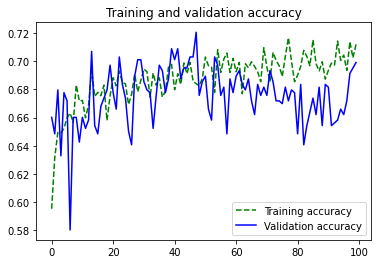

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history2)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model2_acc.png'))

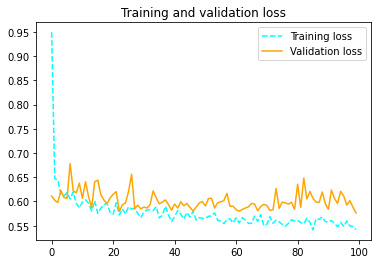

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history2)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model2_loss.png'))

In [ ]:
print_opt_results(history2)

Epoch [end]: 100
Epoch [opt]: 48
Valid accuracy [end]: 0.6992
Valid accuracy [opt]: 0.7207
Valid loss [end]: 0.5763
Valid loss [opt]: 0.5882
Valid precision [end]: 0.5763
Valid precision [opt]: 0.6413
Valid recall [end]: 0.6992
Valid recall [opt]: 0.6942


In [ ]:
test_model(model2)

10/10 [==============================] - 1s 52ms/step - loss: 0.5743 - acc: 0.7063 - prec: 0.5635 - rec: 0.6455 - auc: 0.7482

---------------------------------
Accuracy: 70.63 %
Loss: 0.57 %
Precision: 56.35 %
Recall: 64.55 %
AUC: 0.75
---------------------------------



###Model 3
Dropout 0.5

In [ ]:
model3 = models.Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24,162,337
Trainable params: 2,359,553
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model3.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
history3 = model3.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 28s 299ms/step - loss: 1.1130 - acc: 0.5816 - prec: 0.4872 - rec: 0.5783 - auc: 0.6023 - val_loss: 0.6340 - val_acc: 0.5938 - val_prec: 0.5247 - val_rec: 0.8899 - val_auc: 0.7173
Epoch 2/100
66/66 [==============================] - 17s 257ms/step - loss: 0.6680 - acc: 0.6314 - prec: 0.5412 - rec: 0.6275 - auc: 0.6757 - val_loss: 0.5962 - val_acc: 0.6855 - val_prec: 0.6964 - val_rec: 0.5154 - val_auc: 0.7396
Epoch 3/100
66/66 [==============================] - 16s 244ms/step - loss: 0.6504 - acc: 0.6290 - prec: 0.5376 - rec: 0.6488 - auc: 0.6950 - val_loss: 0.5833 - val_acc: 0.6699 - val_prec: 0.6480 - val_rec: 0.5595 - val_auc: 0.7466
Epoch 4/100
66/66 [==============================] - 16s 244ms/step - loss: 0.6768 - acc: 0.6456 - prec: 0.5560 - rec: 0.6574 - auc: 0.7014 - val_loss: 0.5743 - val_acc: 0.6895 - val_prec: 0.6328 - val_rec: 0.7137 - val_auc: 0.7569
Epoch 5/100
66/66 [==============================] - 16s 242ms/step - lo

In [ ]:
model3.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model3.h5'))

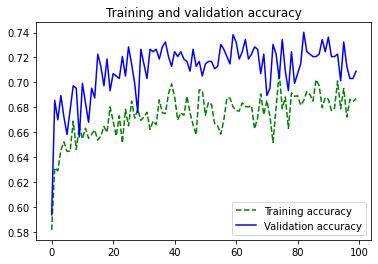

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history3)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model3_acc.png'))

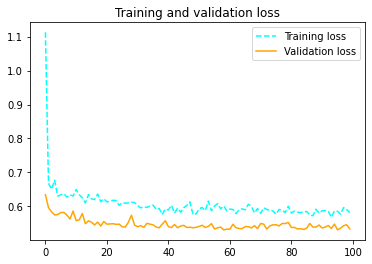

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history3)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model3_loss.png'))

In [ ]:
print_opt_results(history3)

Epoch [end]: 100
Epoch [opt]: 83
Valid accuracy [end]: 0.7090
Valid accuracy [opt]: 0.7402
Valid loss [end]: 0.5331
Valid loss [opt]: 0.5330
Valid precision [end]: 0.5331
Valid precision [opt]: 0.7176
Valid recall [end]: 0.7090
Valid recall [opt]: 0.6828


In [ ]:
model3=load_model(os.path.join(MODEL_PATH,'benmal_inceptionv3_model3.h5'))

In [ ]:
test_model(model3)

10/10 [==============================] - 1s 98ms/step - loss: 0.6189 - acc: 0.6344 - prec: 0.4780 - rec: 0.6909 - auc: 0.7240

---------------------------------
Accuracy: 63.44 %
Loss: 0.62 %
Precision: 47.80 %
Recall: 69.09 %
AUC: 0.72
---------------------------------



###Model 4
Model 2 with learning rate 0.0001

In [ ]:
model4 = models.Sequential()
model4.add(conv_base)
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation='relu'))
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model4.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=METRICS)


In [ ]:
history4 = model4.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 40s 321ms/step - loss: 0.6609 - acc: 0.6148 - prec: 0.5269 - rec: 0.6636 - auc: 0.6719 - val_loss: 0.6159 - val_acc: 0.6504 - val_prec: 0.5623 - val_rec: 0.7731 - val_auc: 0.7235
Epoch 2/100
66/66 [==============================] - 18s 279ms/step - loss: 0.6301 - acc: 0.6357 - prec: 0.5505 - rec: 0.6441 - auc: 0.6950 - val_loss: 0.5973 - val_acc: 0.6484 - val_prec: 0.5600 - val_rec: 0.7778 - val_auc: 0.7429
Epoch 3/100
66/66 [==============================] - 13s 190ms/step - loss: 0.6067 - acc: 0.6589 - prec: 0.5710 - rec: 0.6786 - auc: 0.7242 - val_loss: 0.5884 - val_acc: 0.6621 - val_prec: 0.5915 - val_rec: 0.6435 - val_auc: 0.7437
Epoch 4/100
66/66 [==============================] - 12s 179ms/step - loss: 0.6138 - acc: 0.6570 - prec: 0.5703 - rec: 0.6889 - auc: 0.7257 - val_loss: 0.5888 - val_acc: 0.6758 - val_prec: 0.5868 - val_rec: 0.7824 - val_auc: 0.7513
Epoch 5/100
66/66 [==============================] - 12s 179ms/step - lo

In [ ]:
model4.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model4.h5'))

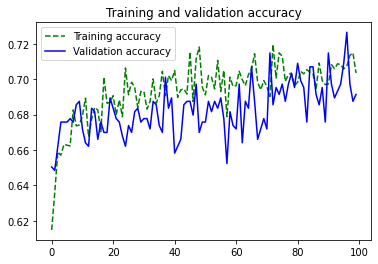

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history4)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model4_acc.png'))

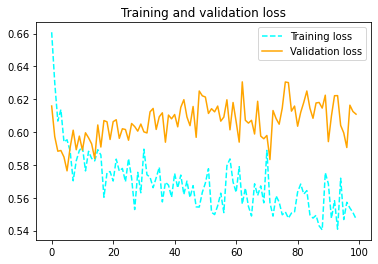

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history4)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model4_loss.png'))

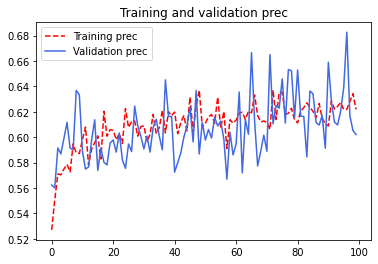

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history4)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model4_prec.png'))

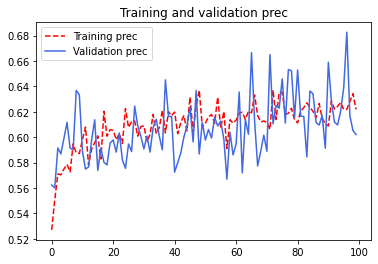

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history4)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model4_rec.png'))

In [ ]:
print_opt_results(history4)

Epoch [end]: 100
Epoch [opt]: 97
Valid accuracy [end]: 0.6914
Valid accuracy [opt]: 0.7266
Valid loss [end]: 0.6110
Valid loss [opt]: 0.5906
Valid precision [end]: 0.6110
Valid precision [opt]: 0.6827
Valid recall [end]: 0.6914
Valid recall [opt]: 0.6574


In [ ]:
test_model(model4)

10/10 [==============================] - 1s 57ms/step - loss: 0.6477 - acc: 0.6250 - prec: 0.4809 - rec: 0.7788 - auc: 0.7527

---------------------------------
Accuracy: 62.50 %
Loss: 0.65 %
Precision: 48.09 %
Recall: 77.88 %
AUC: 0.75
---------------------------------



###Model 5
Model 2 with batch size 64

In [ ]:
model5 = models.Sequential()
model5.add(conv_base)
model5.add(layers.Flatten())
model5.add(layers.Dense(128, activation='relu'))
model5.add(layers.Dropout(0.2))
model5.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model5.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
BATCH_SIZE=64

In [ ]:
history5 = model5.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
33/33 [==============================] - 31s 631ms/step - loss: 1.4692 - acc: 0.5680 - prec: 0.4711 - rec: 0.6175 - auc: 0.6085 - val_loss: 0.6203 - val_acc: 0.6504 - val_prec: 0.5939 - val_rec: 0.5417 - val_auc: 0.7150
Epoch 2/100
33/33 [==============================] - 22s 669ms/step - loss: 0.6370 - acc: 0.6276 - prec: 0.5394 - rec: 0.6783 - auc: 0.6938 - val_loss: 0.6057 - val_acc: 0.6484 - val_prec: 0.5796 - val_rec: 0.6065 - val_auc: 0.7238
Epoch 3/100
33/33 [==============================] - 21s 609ms/step - loss: 0.6208 - acc: 0.6450 - prec: 0.5577 - rec: 0.6667 - auc: 0.7065 - val_loss: 0.6252 - val_acc: 0.6270 - val_prec: 0.5373 - val_rec: 0.8333 - val_auc: 0.7361
Epoch 4/100
33/33 [==============================] - 22s 642ms/step - loss: 0.6253 - acc: 0.6609 - prec: 0.5750 - rec: 0.6953 - auc: 0.7277 - val_loss: 0.5844 - val_acc: 0.6836 - val_prec: 0.6184 - val_rec: 0.6528 - val_auc: 0.7540
Epoch 5/100
33/33 [==============================] - 12s 358ms/step - lo

In [ ]:
model5.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model5.h5'))

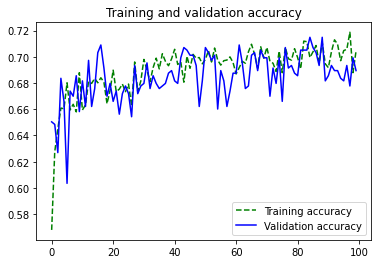

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history5)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model5_acc.png'))

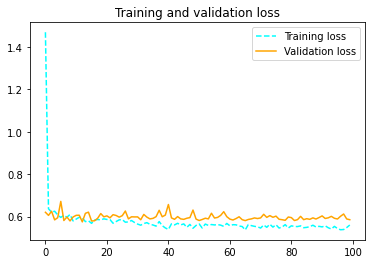

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history5)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model5_loss.png'))

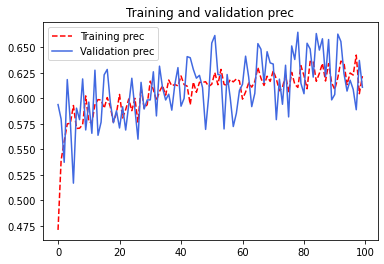

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history5)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model5_prec.png'))

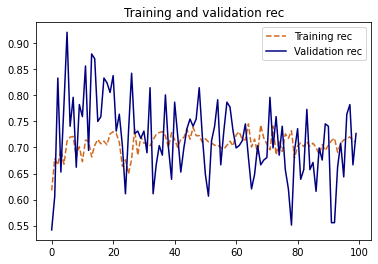

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history5)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model5_rec.png'))

In [ ]:
print_opt_results(history5)

Epoch [end]: 100
Epoch [opt]: 85
Valid accuracy [end]: 0.6895
Valid accuracy [opt]: 0.7148
Valid loss [end]: 0.5853
Valid loss [opt]: 0.5855
Valid precision [end]: 0.5853
Valid precision [opt]: 0.6636
Valid recall [end]: 0.6895
Valid recall [opt]: 0.6574


In [ ]:
test_model(model5)

5/5 [==============================] - 0s 81ms/step - loss: 0.6001 - acc: 0.6844 - prec: 0.5395 - rec: 0.7257 - auc: 0.7505

---------------------------------
Accuracy: 68.44 %
Loss: 0.60 %
Precision: 53.95 %
Recall: 72.57 %
AUC: 0.75
---------------------------------



###Model 6
Model 2 with Adam 


*   learning rate 0.001
*   learning rate 0.0001
*   two dense layer
*   two dense layer with more nodes



####6.1

In [ ]:
model61 = models.Sequential()
model61.add(conv_base)
model61.add(layers.Flatten())
model61.add(layers.Dense(128, activation='relu'))
model61.add(layers.Dropout(0.2))
model61.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model61.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
history61 = model61.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
33/33 [==============================] - 28s 648ms/step - loss: 0.8250 - acc: 0.5947 - prec: 0.5013 - rec: 0.6078 - auc: 0.6294 - val_loss: 0.6353 - val_acc: 0.6035 - val_prec: 0.5225 - val_rec: 0.6991 - val_auc: 0.6745
Epoch 2/100
33/33 [==============================] - 19s 573ms/step - loss: 0.6292 - acc: 0.6416 - prec: 0.5497 - rec: 0.7293 - auc: 0.7089 - val_loss: 0.6204 - val_acc: 0.6504 - val_prec: 0.5627 - val_rec: 0.7685 - val_auc: 0.7240
Epoch 3/100
33/33 [==============================] - 22s 667ms/step - loss: 0.6045 - acc: 0.6488 - prec: 0.5589 - rec: 0.7133 - auc: 0.7235 - val_loss: 0.6015 - val_acc: 0.6367 - val_prec: 0.5524 - val_rec: 0.7315 - val_auc: 0.7349
Epoch 4/100
33/33 [==============================] - 19s 581ms/step - loss: 0.5871 - acc: 0.6855 - prec: 0.6051 - rec: 0.6876 - auc: 0.7511 - val_loss: 0.5907 - val_acc: 0.6523 - val_prec: 0.5754 - val_rec: 0.6713 - val_auc: 0.7469
Epoch 5/100
33/33 [==============================] - 16s 495ms/step - lo

In [ ]:
model61.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model61.h5'))

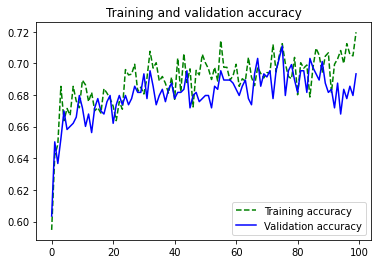

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history61)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model61_acc.png'))

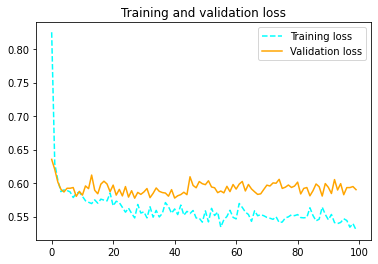

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history61)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model61_loss.png'))

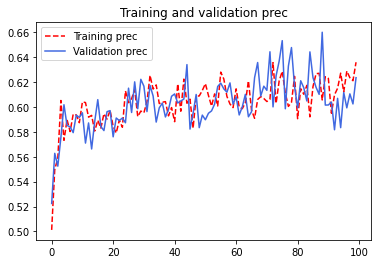

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history61)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model61_prec.png'))

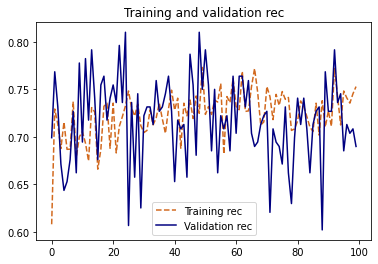

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history61)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model61_rec.png'))

In [ ]:
print_opt_results(history61)

Epoch [end]: 100
Epoch [opt]: 76
Valid accuracy [end]: 0.6934
Valid accuracy [opt]: 0.7109
Valid loss [end]: 0.5901
Valid loss [opt]: 0.5920
Valid precision [end]: 0.5901
Valid precision [opt]: 0.6532
Valid recall [end]: 0.6934
Valid recall [opt]: 0.6713


In [ ]:
test_model(model61)

5/5 [==============================] - 0s 78ms/step - loss: 0.5972 - acc: 0.6625 - prec: 0.5168 - rec: 0.6814 - auc: 0.7543

---------------------------------
Accuracy: 66.25 %
Loss: 0.60 %
Precision: 51.68 %
Recall: 68.14 %
AUC: 0.75
---------------------------------



####6.1.1

In [ ]:
BATCH_SIZE=32

In [ ]:
model611 = models.Sequential()
model611.add(conv_base)
model611.add(layers.Flatten())
model611.add(layers.Dense(128, activation='relu'))
model611.add(layers.Dropout(0.2))
model611.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model611.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
history611 = model611.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 33s 380ms/step - loss: 0.7116 - acc: 0.6096 - prec: 0.5135 - rec: 0.6578 - auc: 0.6549 - val_loss: 0.6176 - val_acc: 0.6367 - val_prec: 0.5701 - val_rec: 0.5648 - val_auc: 0.6985
Epoch 2/100
66/66 [==============================] - 22s 336ms/step - loss: 0.6301 - acc: 0.6181 - prec: 0.5283 - rec: 0.6786 - auc: 0.6960 - val_loss: 0.6007 - val_acc: 0.6367 - val_prec: 0.5647 - val_rec: 0.6065 - val_auc: 0.7216
Epoch 3/100
66/66 [==============================] - 19s 290ms/step - loss: 0.6146 - acc: 0.6656 - prec: 0.5863 - rec: 0.6410 - auc: 0.7208 - val_loss: 0.6372 - val_acc: 0.6016 - val_prec: 0.5152 - val_rec: 0.9398 - val_auc: 0.7484
Epoch 4/100
66/66 [==============================] - 20s 298ms/step - loss: 0.6065 - acc: 0.6461 - prec: 0.5547 - rec: 0.7021 - auc: 0.7252 - val_loss: 0.5996 - val_acc: 0.6523 - val_prec: 0.5576 - val_rec: 0.8519 - val_auc: 0.7736
Epoch 5/100
66/66 [==============================] - 12s 184ms/step - lo

In [ ]:
model611.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model611.h5'))

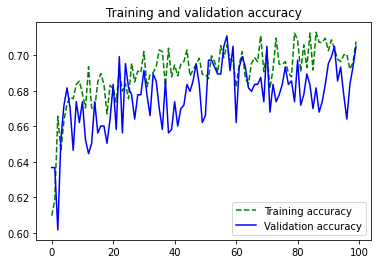

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history611)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model611_acc.png'))

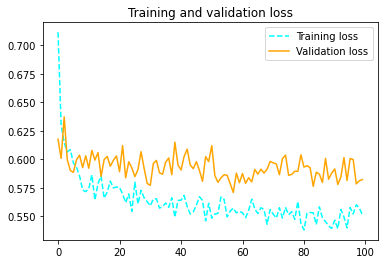

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history611)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model611_loss.png'))

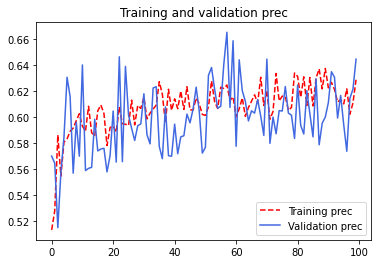

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history611)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model611_prec.png'))

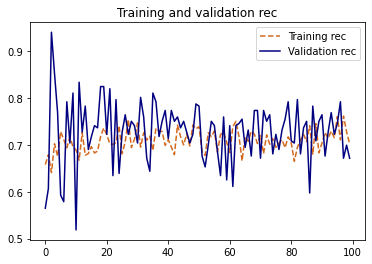

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history611)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model611_rec.png'))

In [ ]:
print_opt_results(history611)

Epoch [end]: 100
Epoch [opt]: 58
Valid accuracy [end]: 0.7051
Valid accuracy [opt]: 0.7109
Valid loss [end]: 0.5821
Valid loss [opt]: 0.5708
Valid precision [end]: 0.5821
Valid precision [opt]: 0.6650
Valid recall [end]: 0.7051
Valid recall [opt]: 0.6343


In [ ]:
test_model(model611)

10/10 [==============================] - 1s 51ms/step - loss: 0.6014 - acc: 0.6812 - prec: 0.5401 - rec: 0.6549 - auc: 0.7449

---------------------------------
Accuracy: 68.12 %
Loss: 0.60 %
Precision: 54.01 %
Recall: 65.49 %
AUC: 0.74
---------------------------------



####6.2

In [ ]:
model62 = models.Sequential()
model62.add(conv_base)
model62.add(layers.Flatten())
model62.add(layers.Dense(128, activation='relu'))
model62.add(layers.Dropout(0.2))
model62.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model62.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=METRICS)


In [ ]:
history62 = model62.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 27s 314ms/step - loss: 0.6720 - acc: 0.6083 - prec: 0.5121 - rec: 0.6493 - auc: 0.6574 - val_loss: 0.6144 - val_acc: 0.6543 - val_prec: 0.5816 - val_rec: 0.6435 - val_auc: 0.7149
Epoch 2/100
66/66 [==============================] - 21s 317ms/step - loss: 0.6199 - acc: 0.6452 - prec: 0.5609 - rec: 0.6548 - auc: 0.7077 - val_loss: 0.5926 - val_acc: 0.6855 - val_prec: 0.6425 - val_rec: 0.5741 - val_auc: 0.7367
Epoch 3/100
66/66 [==============================] - 19s 292ms/step - loss: 0.5987 - acc: 0.6622 - prec: 0.5773 - rec: 0.6820 - auc: 0.7342 - val_loss: 0.6060 - val_acc: 0.6719 - val_prec: 0.5851 - val_rec: 0.7639 - val_auc: 0.7433
Epoch 4/100
66/66 [==============================] - 16s 235ms/step - loss: 0.5974 - acc: 0.6731 - prec: 0.5877 - rec: 0.6912 - auc: 0.7398 - val_loss: 0.5962 - val_acc: 0.6777 - val_prec: 0.6349 - val_rec: 0.5556 - val_auc: 0.7396
Epoch 5/100
66/66 [==============================] - 12s 182ms/step - lo

In [ ]:
model62.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model62.h5'))

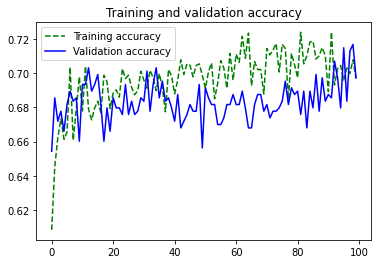

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history62)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model62_acc.png'))

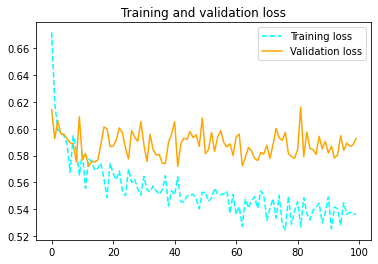

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history62)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model62_loss.png'))

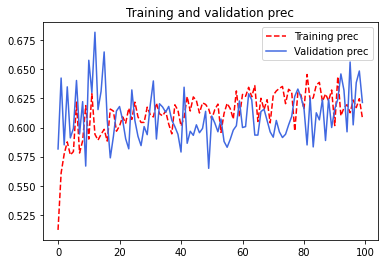

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history62)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model62_prec.png'))

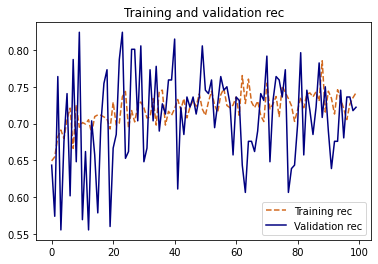

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history62)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model62_rec.png'))

In [ ]:
print_opt_results(history62)

Epoch [end]: 100
Epoch [opt]: 99
Valid accuracy [end]: 0.6973
Valid accuracy [opt]: 0.7168
Valid loss [end]: 0.5926
Valid loss [opt]: 0.5879
Valid precision [end]: 0.5926
Valid precision [opt]: 0.6485
Valid recall [end]: 0.6973
Valid recall [opt]: 0.7176


In [ ]:
test_model(model62)

10/10 [==============================] - 1s 53ms/step - loss: 0.6149 - acc: 0.6750 - prec: 0.5287 - rec: 0.7345 - auc: 0.7527

---------------------------------
Accuracy: 67.50 %
Loss: 0.61 %
Precision: 52.87 %
Recall: 73.45 %
AUC: 0.75
---------------------------------



####6.3 
Model 2 with two dense layer

In [ ]:
model63 = models.Sequential()
model63.add(conv_base)
model63.add(layers.Flatten())
model63.add(layers.Dense(128, activation='relu'))
model63.add(layers.Dropout(0.2))
model63.add(layers.Dense(64, activation='relu'))
model63.add(layers.Dropout(0.2))
model63.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model63.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
history63 = model63.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 30s 319ms/step - loss: 0.9314 - acc: 0.5783 - prec: 0.4819 - rec: 0.5682 - auc: 0.6109 - val_loss: 0.6194 - val_acc: 0.6406 - val_prec: 0.5889 - val_rec: 0.4907 - val_auc: 0.6981
Epoch 2/100
66/66 [==============================] - 24s 366ms/step - loss: 0.7079 - acc: 0.6096 - prec: 0.5260 - rec: 0.5904 - auc: 0.6569 - val_loss: 0.6635 - val_acc: 0.5840 - val_prec: 0.5039 - val_rec: 0.8889 - val_auc: 0.6922
Epoch 3/100
66/66 [==============================] - 12s 182ms/step - loss: 0.6628 - acc: 0.6286 - prec: 0.5421 - rec: 0.6498 - auc: 0.6945 - val_loss: 0.6105 - val_acc: 0.6426 - val_prec: 0.6299 - val_rec: 0.3704 - val_auc: 0.7173
Epoch 4/100
66/66 [==============================] - 12s 184ms/step - loss: 0.6602 - acc: 0.6395 - prec: 0.5584 - rec: 0.5995 - auc: 0.6864 - val_loss: 0.6099 - val_acc: 0.6562 - val_prec: 0.5769 - val_rec: 0.6944 - val_auc: 0.7235
Epoch 5/100
66/66 [==============================] - 12s 183ms/step - lo

In [ ]:
model63.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model63.h5'))

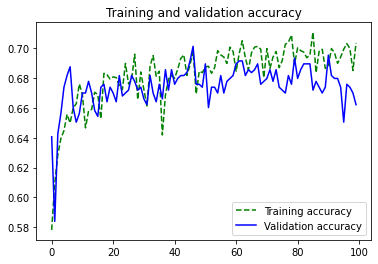

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history63)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model63_acc.png'))

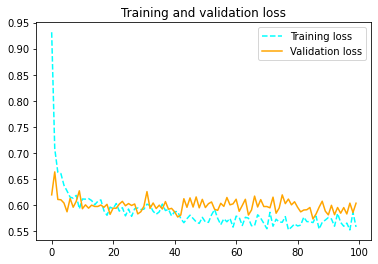

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history63)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model63_loss.png'))

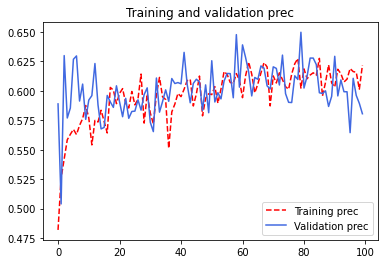

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history63)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model63_prec.png'))

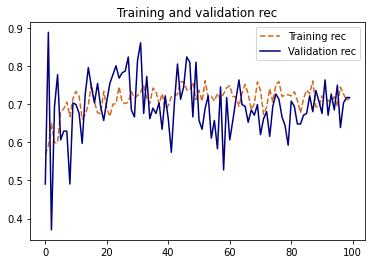

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history63)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model63_rec.png'))

In [ ]:
print_opt_results(history63)

Epoch [end]: 100
Epoch [opt]: 47
Valid accuracy [end]: 0.6621
Valid accuracy [opt]: 0.7012
Valid loss [end]: 0.6033
Valid loss [opt]: 0.5959
Valid precision [end]: 0.6033
Valid precision [opt]: 0.6075
Valid recall [end]: 0.6621
Valid recall [opt]: 0.8241


In [ ]:
test_model(model63)

10/10 [==============================] - 1s 51ms/step - loss: 0.6510 - acc: 0.6469 - prec: 0.5000 - rec: 0.7345 - auc: 0.7373

---------------------------------
Accuracy: 64.69 %
Loss: 0.65 %
Precision: 50.00 %
Recall: 73.45 %
AUC: 0.74
---------------------------------



####6.4 
Two bigger nodes on the dense layer

In [ ]:
model64 = models.Sequential()
model64.add(conv_base)
model64.add(layers.Flatten())
model64.add(layers.Dense(256, activation='relu'))
model64.add(layers.Dropout(0.2))
model64.add(layers.Dense(128, activation='relu'))
model64.add(layers.Dropout(0.2))
model64.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model64.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
history64 = model64.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 32s 385ms/step - loss: 1.1874 - acc: 0.5704 - prec: 0.4755 - rec: 0.5910 - auc: 0.6177 - val_loss: 0.6139 - val_acc: 0.6855 - val_prec: 0.6046 - val_rec: 0.7361 - val_auc: 0.7463
Epoch 2/100
66/66 [==============================] - 16s 248ms/step - loss: 0.7471 - acc: 0.5911 - prec: 0.5043 - rec: 0.6062 - auc: 0.6351 - val_loss: 0.6470 - val_acc: 0.5996 - val_prec: 0.5143 - val_rec: 0.9167 - val_auc: 0.7226
Epoch 3/100
66/66 [==============================] - 12s 183ms/step - loss: 0.6906 - acc: 0.6086 - prec: 0.5213 - rec: 0.6475 - auc: 0.6728 - val_loss: 0.6129 - val_acc: 0.6836 - val_prec: 0.6071 - val_rec: 0.7083 - val_auc: 0.7453
Epoch 4/100
66/66 [==============================] - 12s 177ms/step - loss: 0.6794 - acc: 0.6195 - prec: 0.5342 - rec: 0.6188 - auc: 0.6862 - val_loss: 0.5920 - val_acc: 0.6758 - val_prec: 0.6042 - val_rec: 0.6713 - val_auc: 0.7530
Epoch 5/100
66/66 [==============================] - 12s 176ms/step - lo

In [ ]:
model64.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model64.h5'))

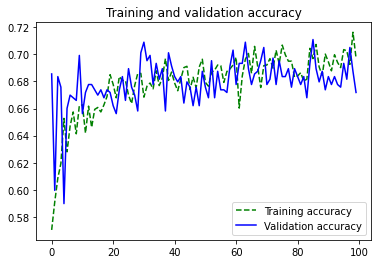

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history64)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model64_acc.png'))

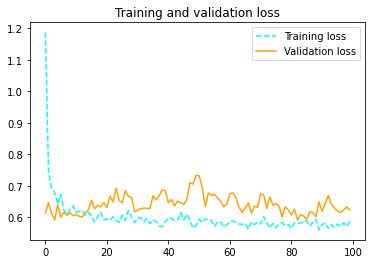

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history64)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model64_loss.png'))

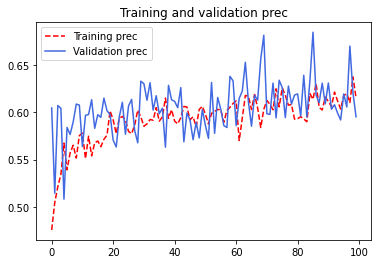

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history64)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model64_prec.png'))

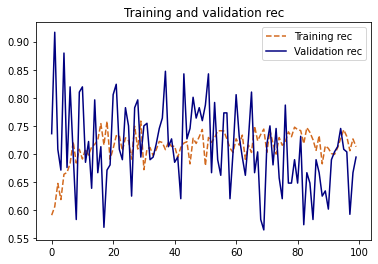

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history64)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model64_rec.png'))

In [ ]:
print_opt_results(history64)

Epoch [end]: 100
Epoch [opt]: 86
Valid accuracy [end]: 0.6719
Valid accuracy [opt]: 0.7109
Valid loss [end]: 0.6230
Valid loss [opt]: 0.5938
Valid precision [end]: 0.6230
Valid precision [opt]: 0.6848
Valid recall [end]: 0.6719
Valid recall [opt]: 0.5833


In [ ]:
test_model(model64)

10/10 [==============================] - 1s 53ms/step - loss: 0.6150 - acc: 0.6656 - prec: 0.5190 - rec: 0.7257 - auc: 0.7470

---------------------------------
Accuracy: 66.56 %
Loss: 0.61 %
Precision: 51.90 %
Recall: 72.57 %
AUC: 0.75
---------------------------------



##Fine Tuning

###Model 7
Model 2 with last level unlocked

In [ ]:
model7 = models.Sequential()
model7.add(conv_base)
model7.add(layers.Flatten())
model7.add(layers.Dense(128, activation='relu'))
model7.add(layers.Dropout(0.2))
model7.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_93 ':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model7.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
history7 = model7.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 20s 298ms/step - loss: 0.6516 - acc: 0.6252 - prec: 0.5321 - rec: 0.6756 - auc: 0.6848 - val_loss: 0.5956 - val_acc: 0.6875 - val_prec: 0.6000 - val_rec: 0.8378 - val_auc: 0.7739
Epoch 2/100
66/66 [==============================] - 17s 249ms/step - loss: 0.6280 - acc: 0.6561 - prec: 0.5654 - rec: 0.6956 - auc: 0.7261 - val_loss: 0.5922 - val_acc: 0.6934 - val_prec: 0.6836 - val_rec: 0.5450 - val_auc: 0.7547
Epoch 3/100
66/66 [==============================] - 12s 182ms/step - loss: 0.6151 - acc: 0.6542 - prec: 0.5639 - rec: 0.6721 - auc: 0.7208 - val_loss: 0.5824 - val_acc: 0.6875 - val_prec: 0.6192 - val_rec: 0.7252 - val_auc: 0.7615
Epoch 4/100
66/66 [==============================] - 13s 200ms/step - loss: 0.6282 - acc: 0.6307 - prec: 0.5371 - rec: 0.6818 - auc: 0.7168 - val_loss: 0.5790 - val_acc: 0.7031 - val_prec: 0.7083 - val_rec: 0.5360 - val_auc: 0.7581
Epoch 5/100
66/66 [==============================] - 13s 195ms/step - lo

In [ ]:
model7.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model7.h5'))

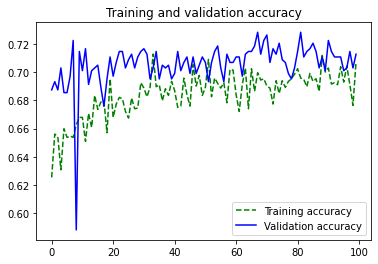

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history7)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model7_acc.png'))

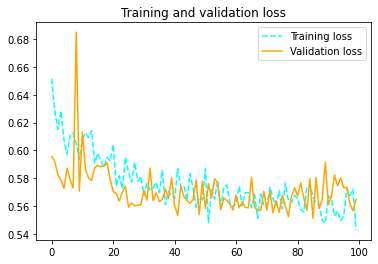

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history7)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model7_loss.png'))

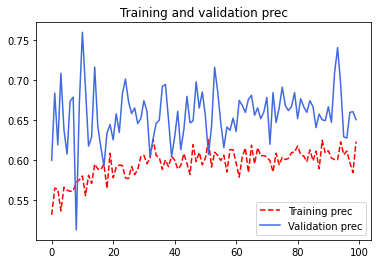

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history7)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model7_prec.png'))

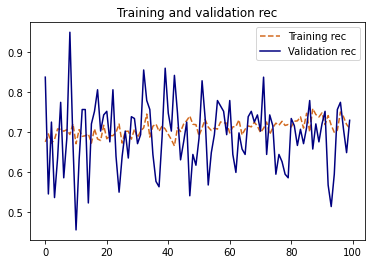

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history7)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model7_rec.png'))

In [ ]:
print_opt_results(history7)

Epoch [end]: 100
Epoch [opt]: 68
Valid accuracy [end]: 0.7129
Valid accuracy [opt]: 0.7285
Valid loss [end]: 0.5649
Valid loss [opt]: 0.5572
Valid precision [end]: 0.5649
Valid precision [opt]: 0.6653
Valid recall [end]: 0.7129
Valid recall [opt]: 0.7523


In [ ]:
test_model(model7)

10/10 [==============================] - 1s 48ms/step - loss: 0.6322 - acc: 0.6219 - prec: 0.4709 - rec: 0.7297 - auc: 0.7332

---------------------------------
Accuracy: 62.19 %
Loss: 0.63 %
Precision: 47.09 %
Recall: 72.97 %
AUC: 0.73
---------------------------------



###Model 7.1
Model 2 with last level unlocked and RMSprop with learning rate 0.0001

In [ ]:
model71 = models.Sequential()
model71.add(conv_base)
model71.add(layers.Flatten())
model71.add(layers.Dense(128, activation='relu'))
model71.add(layers.Dropout(0.2))
model71.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_93 ':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model71.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=METRICS)


In [ ]:
history71 = model71.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 18s 207ms/step - loss: 0.6710 - acc: 0.6124 - prec: 0.5135 - rec: 0.6448 - auc: 0.6655 - val_loss: 0.6076 - val_acc: 0.6582 - val_prec: 0.5983 - val_rec: 0.6441 - val_auc: 0.7213
Epoch 2/100
66/66 [==============================] - 12s 180ms/step - loss: 0.6203 - acc: 0.6570 - prec: 0.5675 - rec: 0.6736 - auc: 0.7167 - val_loss: 0.5997 - val_acc: 0.6699 - val_prec: 0.5930 - val_rec: 0.7613 - val_auc: 0.7471
Epoch 3/100
66/66 [==============================] - 12s 181ms/step - loss: 0.6059 - acc: 0.6793 - prec: 0.5931 - rec: 0.6933 - auc: 0.7279 - val_loss: 0.6231 - val_acc: 0.6348 - val_prec: 0.5504 - val_rec: 0.8604 - val_auc: 0.7416
Epoch 4/100
66/66 [==============================] - 12s 181ms/step - loss: 0.6074 - acc: 0.6651 - prec: 0.5771 - rec: 0.6879 - auc: 0.7321 - val_loss: 0.5919 - val_acc: 0.6641 - val_prec: 0.5850 - val_rec: 0.7748 - val_auc: 0.7490
Epoch 5/100
66/66 [==============================] - 12s 181ms/step - lo

In [ ]:
model71.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model71.h5'))

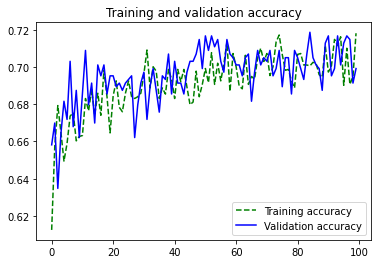

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history71)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model71_acc.png'))

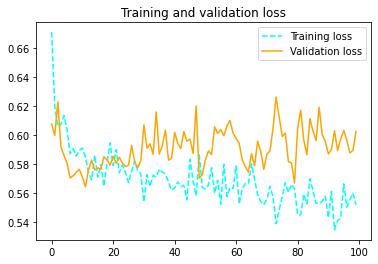

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history71)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model71_loss.png'))

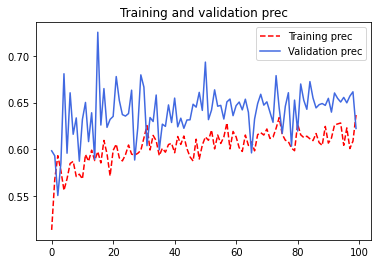

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history71)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model71_prec.png'))

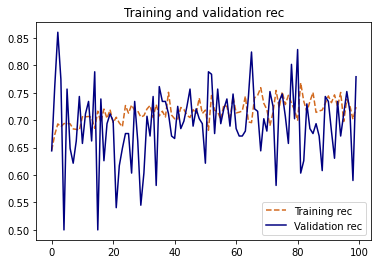

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history71)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model71_rec.png'))

In [ ]:
print_opt_results(history71)

Epoch [end]: 100
Epoch [opt]: 85
Valid accuracy [end]: 0.6992
Valid accuracy [opt]: 0.7188
Valid loss [end]: 0.6025
Valid loss [opt]: 0.6114
Valid precision [end]: 0.6025
Valid precision [opt]: 0.6726
Valid recall [end]: 0.6992
Valid recall [opt]: 0.6847


In [ ]:
test_model(model71)

10/10 [==============================] - 1s 49ms/step - loss: 0.6606 - acc: 0.6031 - prec: 0.4574 - rec: 0.7748 - auc: 0.7382

---------------------------------
Accuracy: 60.31 %
Loss: 0.66 %
Precision: 45.74 %
Recall: 77.48 %
AUC: 0.74
---------------------------------



###Model 8
Model 8 with more level unlocked and RMSprop optimizer with learning rate 0.001

In [ ]:
model8 = models.Sequential()
model8.add(conv_base)
model8.add(layers.Flatten())
model8.add(layers.Dense(128, activation='relu'))
model8.add(layers.Dropout(0.2))
model8.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_87 ':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model8.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
history8 = model8.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 28s 331ms/step - loss: 0.8928 - acc: 0.5840 - prec: 0.4882 - rec: 0.6759 - auc: 0.6387 - val_loss: 0.6413 - val_acc: 0.6426 - val_prec: 0.7010 - val_rec: 0.3063 - val_auc: 0.7088
Epoch 2/100
66/66 [==============================] - 20s 303ms/step - loss: 0.6373 - acc: 0.6219 - prec: 0.5300 - rec: 0.6671 - auc: 0.6935 - val_loss: 0.5984 - val_acc: 0.6777 - val_prec: 0.6770 - val_rec: 0.4910 - val_auc: 0.7516
Epoch 3/100
66/66 [==============================] - 25s 375ms/step - loss: 0.6129 - acc: 0.6471 - prec: 0.5593 - rec: 0.6551 - auc: 0.7188 - val_loss: 0.5927 - val_acc: 0.6699 - val_prec: 0.5936 - val_rec: 0.7568 - val_auc: 0.7631
Epoch 4/100
66/66 [==============================] - 13s 196ms/step - loss: 0.6010 - acc: 0.6622 - prec: 0.5693 - rec: 0.6993 - auc: 0.7343 - val_loss: 0.5973 - val_acc: 0.6641 - val_prec: 0.5912 - val_rec: 0.7297 - val_auc: 0.7524
Epoch 5/100
66/66 [==============================] - 14s 210ms/step - lo

In [ ]:
model8.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model8.h5'))

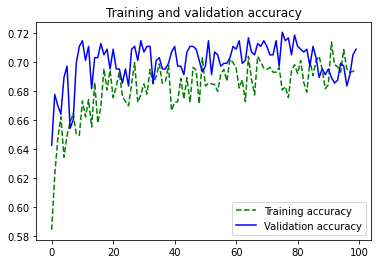

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history8)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model8_acc.png'))

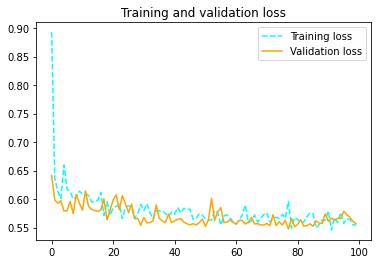

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history8)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model8_loss.png'))

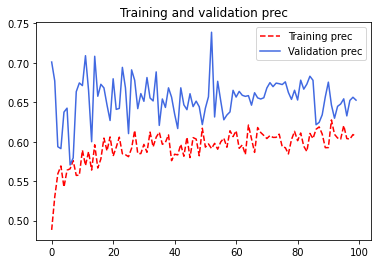

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history8)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model8_prec.png'))

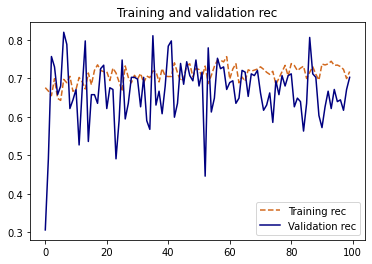

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history8)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model8_rec.png'))

In [ ]:
print_opt_results(history8)

Epoch [end]: 100
Epoch [opt]: 76
Valid accuracy [end]: 0.7090
Valid accuracy [opt]: 0.7207
Valid loss [end]: 0.5571
Valid loss [opt]: 0.5546
Valid precision [end]: 0.5571
Valid precision [opt]: 0.6725
Valid recall [end]: 0.7090
Valid recall [opt]: 0.6937


In [ ]:
test_model(model8)

10/10 [==============================] - 1s 50ms/step - loss: 0.6016 - acc: 0.6344 - prec: 0.4810 - rec: 0.6847 - auc: 0.7437

---------------------------------
Accuracy: 63.44 %
Loss: 0.60 %
Precision: 48.10 %
Recall: 68.47 %
AUC: 0.74
---------------------------------



###Model 9
Model 2 with 200 epochs

In [ ]:
model9 = models.Sequential()
model9.add(conv_base)
model9.add(layers.Flatten())
model9.add(layers.Dense(128, activation='relu'))
model9.add(layers.Dropout(0.2))
model9.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model9.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=METRICS)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [ ]:
history9 = model9.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=200,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    #callbacks=[callback],
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/200
66/66 [==============================] - 36s 270ms/step - loss: 0.8794 - acc: 0.6053 - prec: 0.5242 - rec: 0.6380 - auc: 0.6462 - val_loss: 0.5992 - val_acc: 0.6582 - val_prec: 0.5478 - val_rec: 0.7413 - val_auc: 0.7581
Epoch 2/200
66/66 [==============================] - 15s 230ms/step - loss: 0.6452 - acc: 0.6229 - prec: 0.5405 - rec: 0.6719 - auc: 0.6872 - val_loss: 0.6205 - val_acc: 0.6211 - val_prec: 0.5108 - val_rec: 0.8259 - val_auc: 0.7556
Epoch 3/200
66/66 [==============================] - 16s 241ms/step - loss: 0.6290 - acc: 0.6333 - prec: 0.5482 - rec: 0.6800 - auc: 0.7057 - val_loss: 0.5813 - val_acc: 0.6914 - val_prec: 0.6029 - val_rec: 0.6269 - val_auc: 0.7601
Epoch 4/200
66/66 [==============================] - 15s 229ms/step - loss: 0.6335 - acc: 0.6338 - prec: 0.5519 - rec: 0.6633 - auc: 0.7058 - val_loss: 0.6022 - val_acc: 0.6621 - val_prec: 0.5603 - val_rec: 0.6468 - val_auc: 0.7520
Epoch 5/200
66/66 [==============================] - 15s 233ms/step - lo

In [ ]:
model9.save(os.path.join(MODEL_PATH,'benmal_inceptionv3_model9.h5'))

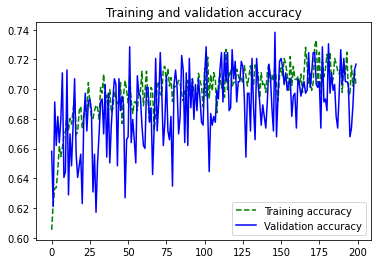

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history9)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model9_acc.png'))

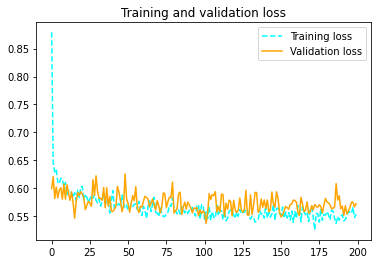

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history9)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model9_loss.png'))

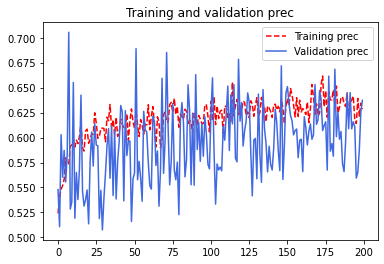

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history9)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model9_prec.png'))

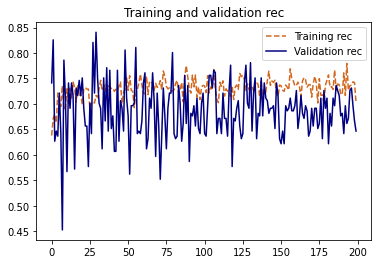

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history9)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_inceptionv3_model9_rec.png'))

In [ ]:
print_opt_results(history9)

Epoch [end]: 200
Epoch [opt]: 147
Valid accuracy [end]: 0.7168
Valid accuracy [opt]: 0.7383
Valid loss [end]: 0.5722
Valid loss [opt]: 0.5660
Valid precision [end]: 0.5722
Valid precision [opt]: 0.6718
Valid recall [end]: 0.7168
Valid recall [opt]: 0.6517


In [ ]:
test_model(model9)

10/10 [==============================] - 1s 104ms/step - loss: 0.5878 - acc: 0.7281 - prec: 0.6094 - rec: 0.6783 - auc: 0.7518

---------------------------------
Accuracy: 72.81 %
Loss: 0.59 %
Precision: 60.94 %
Recall: 67.83 %
AUC: 0.75
---------------------------------



# Print AUC Best Model (3)

###Model9

In [ ]:
model_best=load_model(os.path.join(MODEL_PATH,'benmal_inceptionv3_model9.h5'))

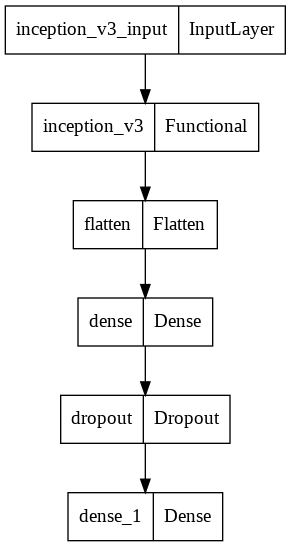

In [ ]:
plot_model(model_best)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model_best.evaluate(test_datagen.flow(test_images,
                                          test_labels,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False),
                                          steps=len(test_images) // BATCH_SIZE)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Loss:", "%0.2f" % (test_loss), "%")
print("Precision:", "%0.2f" % (test_precision*100), "%")
print("Recall:", "%0.2f" % (test_recall*100), "%")
print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

10/10 [==============================] - 5s 118ms/step - loss: 0.5964 - acc: 0.7250 - prec: 0.5827 - rec: 0.6789 - auc: 0.7417

---------------------------------
Accuracy: 72.50 %
Loss: 0.60 %
Precision: 58.27 %
Recall: 67.89 %
AUC: 0.74
---------------------------------



(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       219
         1.0       0.59      0.68      0.63       117

    accuracy                           0.73       336
   macro avg       0.70      0.71      0.71       336
weighted avg       0.74      0.73      0.73       336



Text(0.5, -6.819805153394636, 'Predicted label')

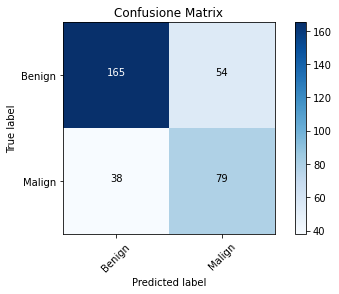

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+2,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)


print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

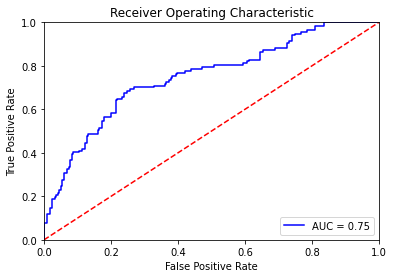

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###Model2

In [ ]:
model_best=load_model(os.path.join(MODEL_PATH,'benmal_inceptionv3_model2.h5'))

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model_best.evaluate(test_datagen.flow(test_images,
                                          test_labels,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False),
                                          steps=len(test_images) // BATCH_SIZE)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Loss:", "%0.2f" % (test_loss), "%")
print("Precision:", "%0.2f" % (test_precision*100), "%")
print("Recall:", "%0.2f" % (test_recall*100), "%")
print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

10/10 [==============================] - 5s 104ms/step - loss: 0.5812 - acc: 0.7031 - prec: 0.5538 - rec: 0.6606 - auc: 0.7447

---------------------------------
Accuracy: 70.31 %
Loss: 0.58 %
Precision: 55.38 %
Recall: 66.06 %
AUC: 0.74
---------------------------------



(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76       219
         1.0       0.57      0.66      0.61       117

    accuracy                           0.71       336
   macro avg       0.68      0.69      0.69       336
weighted avg       0.72      0.71      0.71       336



Text(0.5, -6.819805153394636, 'Predicted label')

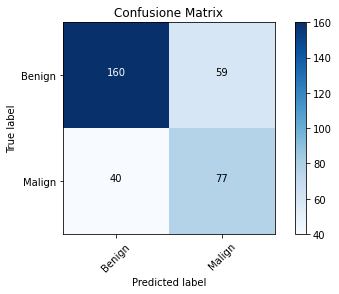

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+2,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)


print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

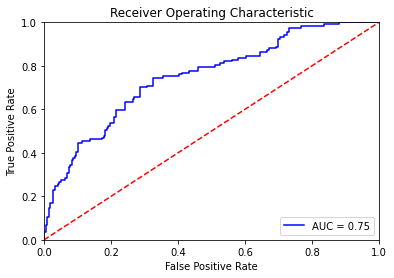

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()